In [2]:
import os 
import sys 
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
# Pytorch module 
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

import pytorch_lightning as pl

import random
from typing import Any, Mapping
from time import gmtime, strftime

# set working directory
os.chdir('/home/jovyan/contrails/contrails_detection/')

# Project Module
import config
import src.utils as utils
from src.dataset import ContrailsDataset
from src.model import BaseUnet, SegmentLightning
from src.train import Trainer
from src.trainer_lgt import TrainerLightning

In [3]:
## Load file from csv split into train/test
from sklearn.model_selection import train_test_split
df = pd.read_csv(config.CSV_TRAIN_REC, index_col=0)
train_df, valid_df = train_test_split(df[df.Class.isin([0,1])], test_size = .2, random_state=42)
train_df.tail()

,Image_ID,Class
11284,3816590513509902394,0
11964,3297656212779292773,0
5390,5369159359735899734,1
860,1431026080843722872,0
15795,1111066390974440788,1


## 1. Dataset Collection & Preparation 

- images into xarray dataset with 9 bands and mask
- image data split at class label-0, 1 (ds_0, ds_1)
- pixels split at mask value 0 and 1 (ds_mask_0, ds_mask_1)

In [12]:
## !utils.py Functions 
# Load image data and prepare into xarray 
import xarray as xr
import numpy as np
from pathlib import Path

def images_list(img_dir, df):
    image_list = []
    mask_list = []

    for index, row in df.iterrows():
        img_name = row['Image_ID']

        img_path = Path(img_dir) / str(img_name)

        # Convert the Path objects to strings
        mask_path = f"{img_path}/human_pixel_masks.npy"
        image_paths = [img_path / f"band_{band:02d}.npy" for band in range(8, 17)]

        # Load image and mask
        image = np.array([np.load(str(path)) for path in image_paths])
        mask = np.load(mask_path)

        image_list.append(image[..., 4])  # Select only the 5th image from the sequence
        mask_list.append(mask)

    return image_list, mask_list

def load_images_to_dataset(img_dir, df):
    img_list, mask_list = images_list(img_dir, df)
    
    # Stack images along the band dimension
    img_concatenated = np.stack(img_list, axis=-1)
    print(img_concatenated.shape)
    # Stack masks along the band dimension
    img_ids = np.repeat(df['Image_ID'], img_concatenated.shape[-1] // len(df))

    # Stack masks along the band dimension
    mask_concatenated = np.stack(mask_list, axis=-1)  # Stack along the first axis
    mask_concatenated = np.squeeze(mask_concatenated, axis=2)
    print(mask_concatenated.shape)

    # Create xarray dataset
    data_vars = {}
    for i in range(img_concatenated.shape[0]):
        data_vars[f'band_{i+8}'] = (('y', 'x', 'band'), img_concatenated[i])
    data_vars['mask'] = (('y', 'x', 'band'), mask_concatenated)

    # Add image IDs as a coordinate
    coords = {'y': np.arange(img_concatenated.shape[1]),
              'x': np.arange(img_concatenated.shape[2]),
              'image_id': img_ids}

    dataset = xr.Dataset(data_vars, coords=coords)

    return dataset

## Data summary 
def compute_summary_statistics(dataset):
    summary_stats = {}
    for var_name in dataset.data_vars:
        data = dataset[var_name].values.flatten()
        summary_stats[var_name] = {
            'min': np.min(data),
            'max': np.max(data),
            'mean': np.mean(data),
            'median': np.median(data),
            'std': np.std(data),
            'percentile_25': np.percentile(data, 25),
            'percentile_75': np.percentile(data, 75),
            'count': np.count_nonzero(~np.isnan(data))
        }
    return summary_stats

## Visualization 
import seaborn as sns
def plot_bands_histograms(dataset, title, save_path, plot_name):
    # Initialize a seaborn plot
    plt.figure(figsize=(10, 6))
    
    # Set seaborn style
    sns.set(style="whitegrid")
    
    # Define a sequential colormap
    cmap = plt.cm.get_cmap('tab20b', len(dataset.data_vars))

    # Create a KDE plot for each variable with sequential coloring
    for i, var_name in enumerate(dataset.data_vars):
        sns.kdeplot(dataset[var_name].values.flatten(), linewidth=2, label=var_name, color=cmap(i))

    # Add legend
    plt.legend()

    # Set labels and title
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title(title)

    # Save the plot to the specified path with the specified plot name
    plt.savefig(f"{save_path}/{plot_name}.png")

    # Show plot
    plt.show()

In [7]:
%%time
# Example usage:
sdf = train_df.sample(1000)
img_dir = config.DATA_DIR + 'train'
ds = load_images_to_dataset(img_dir, sdf)

(9, 256, 256, 1000)
(256, 256, 1000)
CPU times: user 16.6 s, sys: 19.2 s, total: 35.8 s
Wall time: 47.7 s


In [8]:
ds

<xarray.Dataset>
Dimensions:   (y: 256, x: 256, band: 1000, image_id: 1000)
Coordinates:
  * y         (y) int64 0 1 2 3 4 5 6 7 8 ... 248 249 250 251 252 253 254 255
  * x         (x) int64 0 1 2 3 4 5 6 7 8 ... 248 249 250 251 252 253 254 255
  * image_id  (image_id) int64 6442550432609384556 ... 4350274390630711929
Dimensions without coordinates: band
Data variables:
    band_8    (y, x, band) float32 239.0 236.9 227.2 232.4 ... 219.9 241.4 235.4
    band_9    (y, x, band) float32 248.0 247.3 231.9 240.1 ... 221.6 253.7 248.6
    band_10   (y, x, band) float32 257.4 256.7 235.5 247.3 ... 222.6 263.7 262.0
    band_11   (y, x, band) float32 287.5 275.7 243.6 263.7 ... 224.3 278.0 292.8
    band_12   (y, x, band) float32 260.9 254.8 233.6 249.1 ... 226.0 253.8 263.2
    band_13   (y, x, band) float32 290.4 277.6 243.7 265.4 ... 224.5 280.1 295.6
    band_14   (y, x, band) float32 290.5 277.7 242.6 263.5 ... 223.3 280.3 295.8
    band_15   (y, x, band) float32 288.5 276.5 241.0 260.8 ... 222.3 279.3 293.8
    band_16   (y, x, band) float32 272.0 264.5 236.4 253.4 ... 221.6 268.3 275.4
    mask      (y, x, band) int32 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0

### Image dataset for Class 0 & 1

In [10]:
!pwd

/home/jovyan/contrails/contrails_detection


In [11]:
train_mask = pd.read_csv('../data/train_mask_record.csv')

In [15]:
train_mask.groupby('Class').count()

,Unnamed: 0,Image_ID
Class,,
0,11270,11270
1,9259,9259


In [9]:
%%time

## Image files pandas dataframe sdampling
noCont_df = sdf[sdf.Class==0]
Cont_df = sdf[sdf.Class==1]

CPU times: user 6.43 ms, sys: 0 ns, total: 6.43 ms
Wall time: 4.88 ms


In [10]:
%%time
# Make xarray dataset from pandas df sampling
noCont_ds = load_images_to_dataset(img_dir, noCont_df)
Cont_ds = load_images_to_dataset(img_dir, Cont_df)

(9, 256, 256, 543)
(256, 256, 543)
(9, 256, 256, 457)
(256, 256, 457)
CPU times: user 15.7 s, sys: 14.7 s, total: 30.4 s
Wall time: 33.9 s


### Image pixels dataset at mask value 0 and 1

In [22]:
Cont_ds

<xarray.Dataset>
Dimensions:   (y: 256, x: 256, band: 459, image_id: 459)
Coordinates:
  * y         (y) int64 0 1 2 3 4 5 6 7 8 ... 248 249 250 251 252 253 254 255
  * x         (x) int64 0 1 2 3 4 5 6 7 8 ... 248 249 250 251 252 253 254 255
  * image_id  (image_id) int64 1168680127144148790 ... 9037065046651353748
Dimensions without coordinates: band
Data variables:
    band_8    (y, x, band) float32 238.0 232.6 233.2 234.9 ... 236.2 241.3 241.8
    band_9    (y, x, band) float32 247.2 241.8 241.9 245.1 ... 246.5 251.6 253.0
    band_10   (y, x, band) float32 255.9 254.6 254.1 253.7 ... 256.7 262.5 260.6
    band_11   (y, x, band) float32 287.8 282.4 288.9 275.3 ... 286.2 292.5 285.9
    band_12   (y, x, band) float32 268.0 260.1 260.6 247.0 ... 261.2 270.9 258.4
    band_13   (y, x, band) float32 290.9 284.9 292.0 277.3 ... 289.5 295.5 289.2
    band_14   (y, x, band) float32 289.3 285.2 290.9 277.4 ... 288.6 295.4 288.6
    band_15   (y, x, band) float32 285.2 283.7 286.6 275.9 ... 285.3 292.8 285.6
    band_16   (y, x, band) float32 270.6 270.9 268.9 261.9 ... 270.6 277.0 268.9
    mask      (y, x, band) int32 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0

In [22]:
%%time
ds1_without_mask = Cont_ds.drop_vars('mask')
ds1_mean = ds1_without_mask.mean()
ds0_without_mask = noCont_ds.drop_vars('mask')
ds0_mean = ds0_without_mask.mean()
ds0_mean.to_array().mean()

CPU times: user 1.97 s, sys: 1.32 s, total: 3.29 s
Wall time: 3.29 s


<xarray.DataArray ()>
array(258.81607, dtype=float32)

In [30]:
ds1_mean.to_array().mean()

<xarray.DataArray ()>
array(261.1899, dtype=float32)

In [11]:
%%time
## Dataset splits
# Image mask with label 0 and 1
ds_mask_0 = ds.where(ds['mask'] == 0, drop=True).drop_vars('mask')
ds_mask_1 = ds.where(ds['mask'] == 1, drop=True).drop_vars('mask')

ds_mask_0

CPU times: user 8.52 s, sys: 4.51 s, total: 13 s
Wall time: 13 s


<xarray.Dataset>
Dimensions:   (y: 256, x: 256, band: 1000, image_id: 1000)
Coordinates:
  * y         (y) int64 0 1 2 3 4 5 6 7 8 ... 248 249 250 251 252 253 254 255
  * x         (x) int64 0 1 2 3 4 5 6 7 8 ... 248 249 250 251 252 253 254 255
  * image_id  (image_id) int64 6442550432609384556 ... 4350274390630711929
Dimensions without coordinates: band
Data variables:
    band_8    (y, x, band) float32 239.0 236.9 227.2 232.4 ... 219.9 241.4 235.4
    band_9    (y, x, band) float32 248.0 247.3 231.9 240.1 ... 221.6 253.7 248.6
    band_10   (y, x, band) float32 257.4 256.7 235.5 247.3 ... 222.6 263.7 262.0
    band_11   (y, x, band) float32 287.5 275.7 243.6 263.7 ... 224.3 278.0 292.8
    band_12   (y, x, band) float32 260.9 254.8 233.6 249.1 ... 226.0 253.8 263.2
    band_13   (y, x, band) float32 290.4 277.6 243.7 265.4 ... 224.5 280.1 295.6
    band_14   (y, x, band) float32 290.5 277.7 242.6 263.5 ... 223.3 280.3 295.8
    band_15   (y, x, band) float32 288.5 276.5 241.0 260.8 ... 222.3 279.3 293.8
    band_16   (y, x, band) float32 272.0 264.5 236.4 253.4 ... 221.6 268.3 275.4

## 2. Data Exploration & Analysis

### Summary 

In [35]:
# Example usage:
summary_stats_c0 = compute_summary_statistics(Cont_ds)

# Convert the summary statistics dictionary to a pandas DataFrame
df_summary_c0 = pd.DataFrame(summary_stats_c0).T
print('Summary stats of dataset for Contrails Image')
df_summary_c0

Summary stats of dataset for Contrails Image


,min,max,mean,median,std,percentile_25,percentile_75,count
band_8,187.188782,259.984894,233.095322,233.318512,5.879419,229.557678,236.685394,30081024.0
band_9,184.873627,270.119781,242.223862,243.076660,7.748860,238.031570,247.117569,30081024.0
band_10,185.423965,282.723541,251.356750,253.313751,9.612460,246.913040,257.720581,30081024.0
band_11,183.779724,326.045898,276.422089,281.276367,16.742044,269.142883,288.449341,30081024.0
band_12,207.191269,297.314484,254.733292,256.369354,11.502706,247.613327,263.152161,30081024.0
band_13,184.046921,331.485748,278.789490,283.753845,17.772144,270.726349,291.677917,30081024.0
band_14,183.199890,332.154938,277.668610,282.947784,18.234673,268.936981,290.975098,30081024.0
band_15,182.741943,328.182373,274.884247,280.348846,17.808468,266.134216,287.836884,30081024.0
band_16,185.002548,302.082214,261.535400,265.723938,13.550829,254.883633,271.579529,30081024.0
mask,0.000000,1.000000,0.010564,0.000000,0.102236,0.000000,0.000000,30081024.0


In [36]:
# Example usage:
summary_stats_c1 = compute_summary_statistics(noCont_ds)

# Convert the summary statistics dictionary to a pandas DataFrame
df_summary_c1 = pd.DataFrame(summary_stats_c1).T
print('Summary stats of dataset for non-Contrails Image')

df_summary_c1

Summary stats of dataset for non-Contrails Image


,min,max,mean,median,std,percentile_25,percentile_75,count
band_8,185.284470,262.344147,233.885880,234.963867,7.936618,230.350327,238.637939,35454976.0
band_9,182.563431,273.980743,241.863113,243.839935,10.332422,237.634338,248.252396,35454976.0
band_10,183.246933,278.901031,249.692230,253.348389,12.736192,244.550934,258.017670,35454976.0
band_11,181.368668,317.041656,271.404999,279.066071,21.457237,260.254234,287.863617,35454976.0
band_12,205.654694,287.471802,255.268738,258.776062,14.511443,246.345566,267.268250,35454976.0
band_13,181.935532,322.980286,273.345215,281.193146,22.532049,261.156921,290.825531,35454976.0
band_14,180.669922,323.332916,271.955933,279.953674,22.860071,259.030571,289.872803,35454976.0
band_15,180.107712,317.480530,269.223389,277.226654,22.265905,256.423309,286.678925,35454976.0
band_16,182.861359,292.024628,258.506317,264.813690,17.498177,249.037689,272.092621,35454976.0
mask,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35454976.0


### Visualization

In [23]:
fig_path = "reports/figures/"
name_plt1 = "eda_image_all_bands"
name_plt2 = "eda_image_contrails_bands"
name_plt3 = "eda_image_Nocontrails_bands"
name_plt4 = "eda_image_contrails_pixels"
name_plt5 = "eda_image_Nocontrails_pixels"

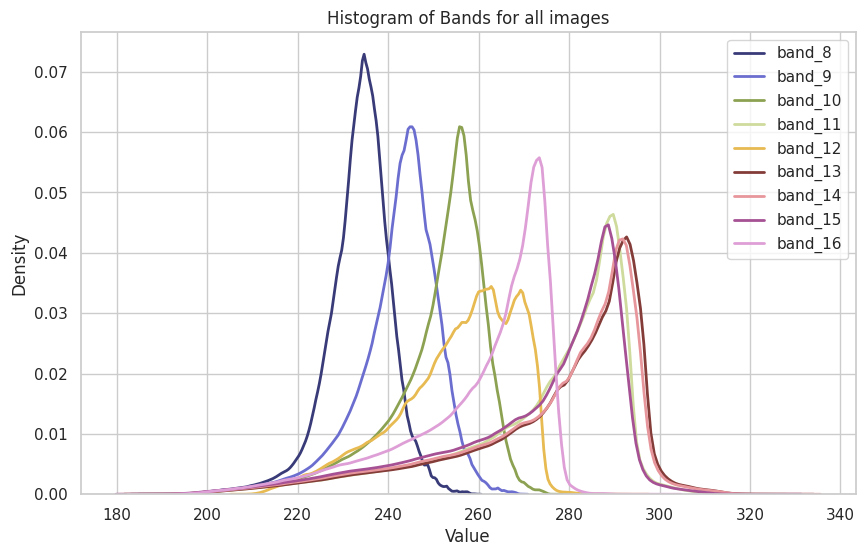

CPU times: user 52min 6s, sys: 3min 19s, total: 55min 25s
Wall time: 51min 37s


In [24]:
%%time
ds_all = ds.drop_vars('mask')
plot_bands_histograms(ds_all, 'Histogram of Bands for all images', fig_path, name_plt1)

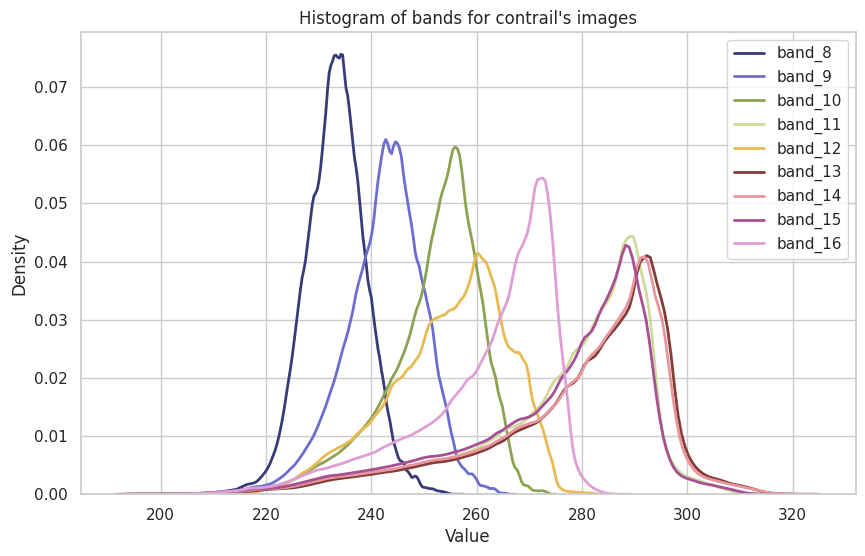

CPU times: user 24min 24s, sys: 2min 29s, total: 26min 53s
Wall time: 23min 25s


In [25]:
%%time
plot_bands_histograms(ds1_without_mask, "Histogram of bands for contrail's images", fig_path, name_plt2)

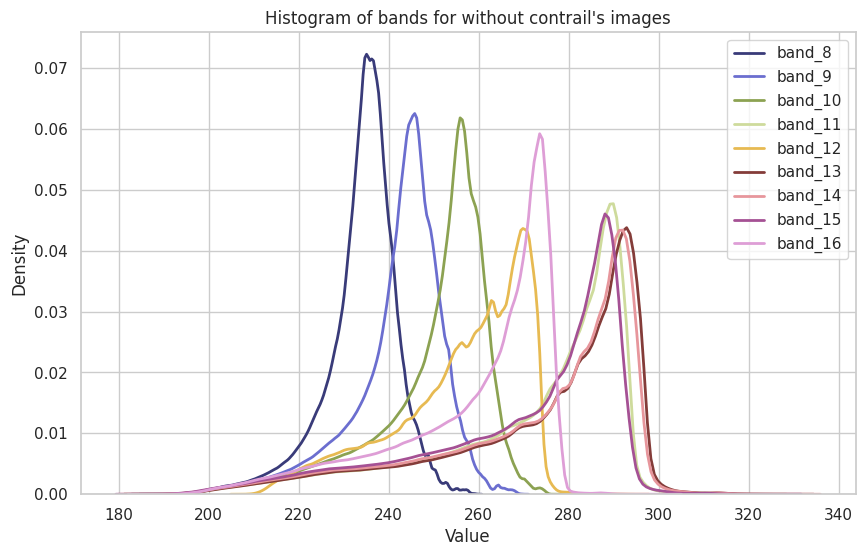

CPU times: user 28min 41s, sys: 2min 41s, total: 31min 23s
Wall time: 27min 40s


In [26]:
%%time
plot_bands_histograms(ds0_without_mask, "Histogram of bands for without contrail's images", fig_path, name_plt3)

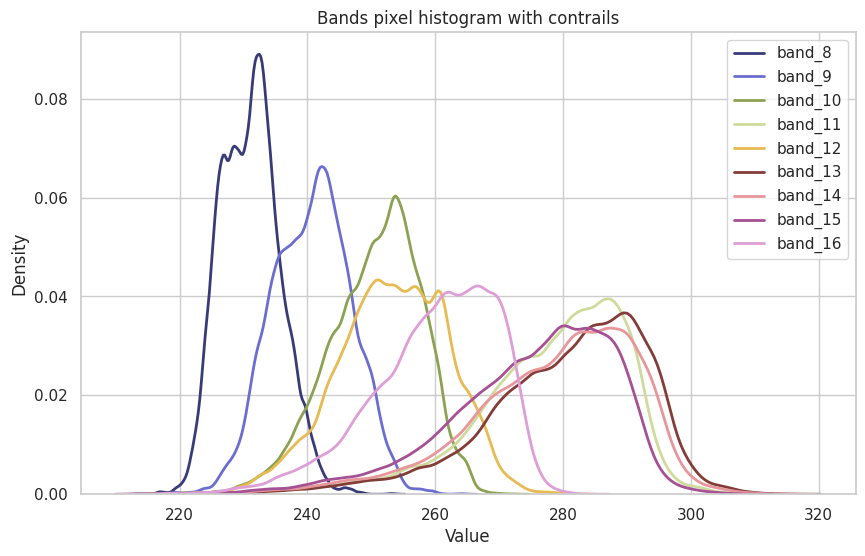

In [27]:
plot_bands_histograms(ds_mask_1, 'Bands pixel histogram with contrails', fig_path, name_plt4)

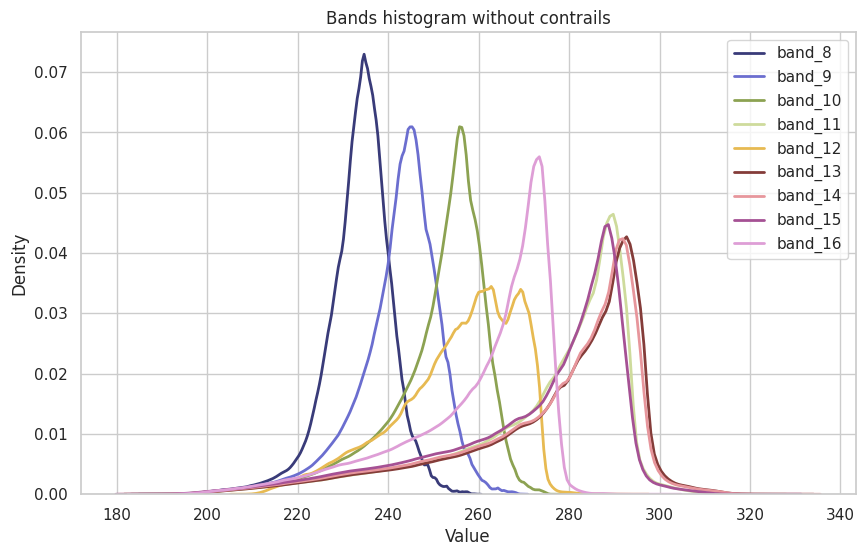

In [28]:
plot_bands_histograms(ds_mask_0, 'Bands histogram without contrails', fig_path, name_plt5)

## 3. Bands Comparison

In [73]:
# Box plots for ABI bands
def plot_bands_boxplots(dataset, title):
    # Define a colormap
    cmap = plt.cm.get_cmap('tab20b', len(dataset.data_vars))

    # Initialize a figure
    plt.figure(figsize=(12, 6))
    
    # Extract variable values and plot box plots for each variable
    for i, var_name in enumerate(dataset.data_vars):
        plt.boxplot(dataset[var_name].values.flatten(), 
                    positions=[int(var_name.split('_')[1])],
                    patch_artist=True,
                    boxprops=dict(facecolor=cmap(i)))

    # Set title and labels
    plt.title(title) #'Bands Box Plots of All Data'
    plt.xlabel('Bands')
    plt.ylabel('Values')

    # Show plot
    plt.show()

IndexError: list index out of range

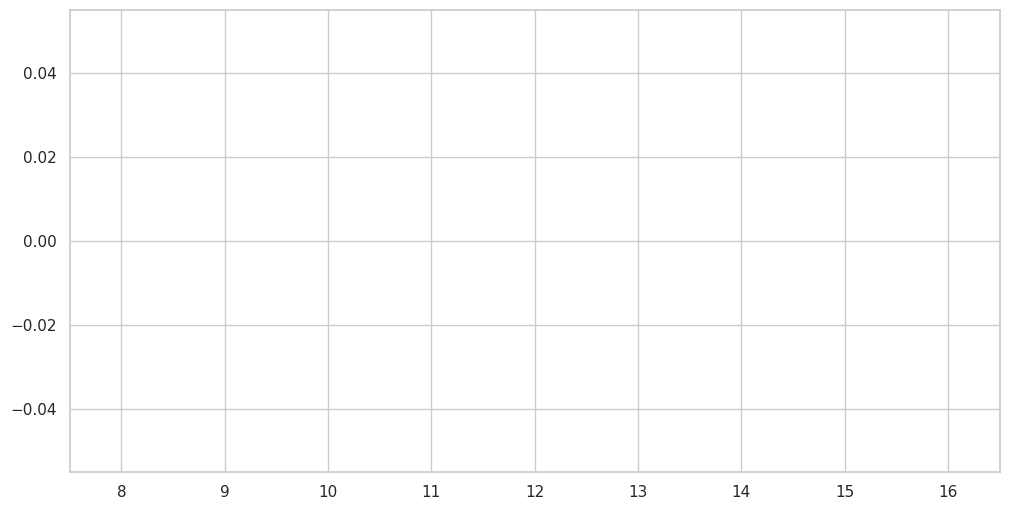

In [169]:
%%time
plot_bands_boxplots(ds_mask_0, 'Bands Box Plots of All Data')

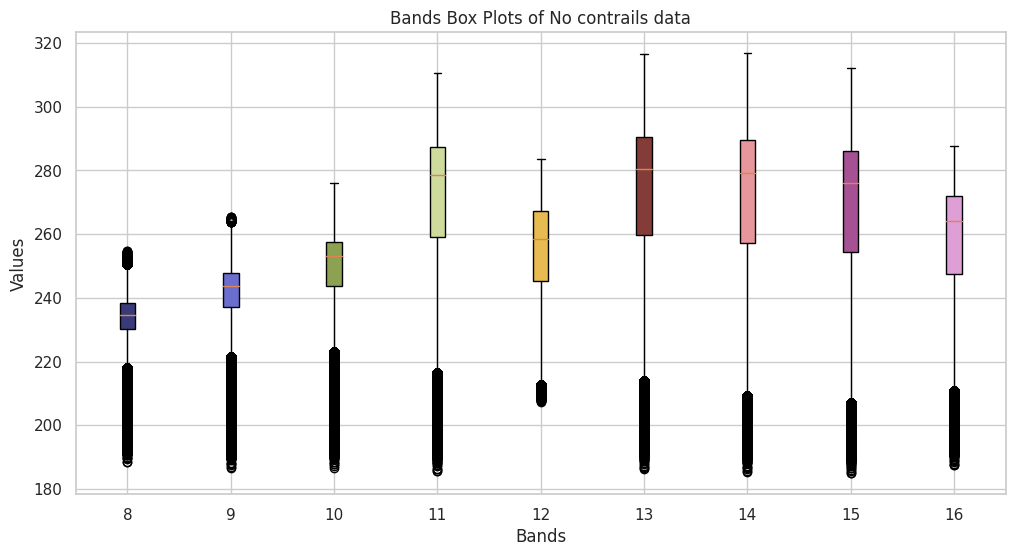

CPU times: user 3.88 s, sys: 309 ms, total: 4.19 s
Wall time: 3.93 s


In [75]:
%%time
plot_bands_boxplots(ds_c0, 'Bands Box Plots of No contrails data')

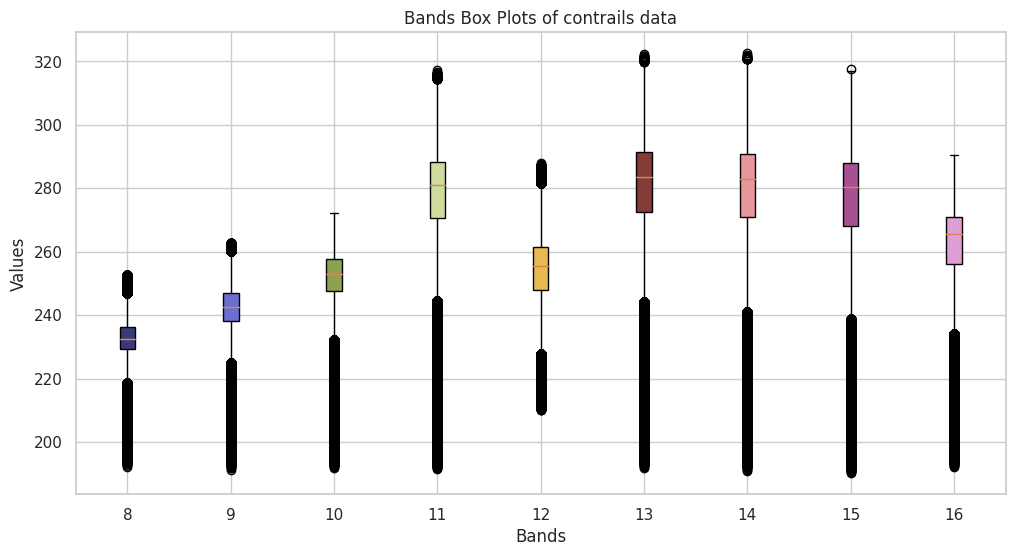

CPU times: user 4.67 s, sys: 164 ms, total: 4.84 s
Wall time: 4.57 s


In [77]:
%%time
plot_bands_boxplots(ds_c1, 'Bands Box Plots of contrails data')

## 4. Class Comparisons 

## 5. Unsupervised Modeling/Clustering

## 6. Result & Output